In [22]:
%matplotlib inline

# Conditional clade probability summaries

## Edit primates data to five taxa
Five taxa is the smallest where we actually have to make the conditional independence assumption; we might observe a clade of greater than size 2 as the child of different parents.

In [23]:
from Bio.Nexus.Nexus import Nexus

nexus = Nexus()
nexus.read('../data/Influenza.nexus')
nexus

In [24]:
nexus.taxlabels

['CY068129_A_California_VRDL396_2009_2009/04/28',
 'CY068870_A_California_VRDL392_2009_2009/04/28',
 'CY068686_A_California_VRDL181_2009_2009/04/28',
 'CY068137_A_California_VRDL159_2009_2009/04/28',
 'CY068217_A_California_VRDL173_2009_2009/04/28',
 'CY068702_A_California_VRDL184_2009_2009/04/28',
 'CY068742_A_California_VRDL199_2009_2009/04/28',
 'CY068766_A_California_VRDL204_2009_2009/04/28',
 'CY068718_A_California_VRDL187_2009_2009/04/28',
 'CY068209_A_California_VRDL172_2009_2009/04/28',
 'CY064879_A_California_VRDL147_2009_2009/04/28',
 'CY068678_A_California_VRDL178_2009_2009/04/28',
 'CY068233_A_California_VRDL211_2009_2009/04/28',
 'CY068734_A_California_VRDL198_2009_2009/04/28',
 'CY068633_A_California_VRDL394_2009_2009/04/28',
 'CY068153_A_California_VRDL161_2009_2009/04/28',
 'CY068161_A_California_VRDL164_2009_2009/04/28',
 'CY067221_A_California_VRDL302_2009_2009/04/28',
 'CY068758_A_California_VRDL203_2009_2009/04/28',
 'CY092329_A_California_VRDL182_2009_2009/04/28',


In [80]:
# TODO: Return all with 5 taxa
nexus.write_nexus_data('../data/Influenza-short.nex', delete=nexus.taxlabels[5:])

'../data/Influenza-short.nex'

## Data structures for conditional clades

In [26]:
from splits import Split

## Processing MCMC output

In [27]:
from Bio import Phylo
trees = list(Phylo.parse('../data/Influenza-short.trees', format='nexus'))
len(trees)

10001

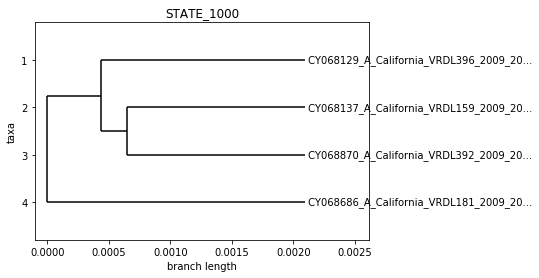

In [28]:
tree = trees[1]
Phylo.draw(tree)

In [29]:
def get_taxa(clade):
    return frozenset([leaf.name for leaf in clade.get_terminals()])
clade = list(tree.find_clades())[2]
clade.branch_length, get_taxa(clade)

(0.0016604658705306958,
 frozenset({'CY068129_A_California_VRDL396_2009_2009/04/28'}))

In [30]:
all_taxa = list(get_taxa(tree.root))
name_mapping = { name: str(i) for i, name in enumerate(all_taxa)}
name_mapping

{'CY068129_A_California_VRDL396_2009_2009/04/28': '0',
 'CY068137_A_California_VRDL159_2009_2009/04/28': '2',
 'CY068686_A_California_VRDL181_2009_2009/04/28': '3',
 'CY068870_A_California_VRDL392_2009_2009/04/28': '1'}

In [31]:
for tree in trees:
    for clade in tree.find_clades():
        if clade.name is not None:
            clade.name = name_mapping[clade.name]

list(tree.find_clades())

[Clade(branch_length=0.0),
 Clade(branch_length=0.001610199693661754),
 Clade(branch_length=0.002607478011988455, name='0'),
 Clade(branch_length=0.0011313513390237963),
 Clade(branch_length=0.0014761266729646585, name='2'),
 Clade(branch_length=0.0014761266729646585, name='3'),
 Clade(branch_length=0.004217677705650209, name='1')]

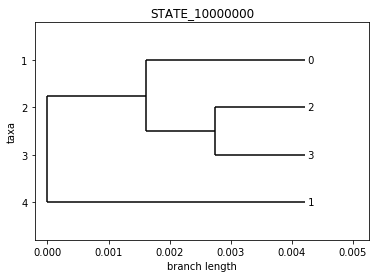

In [47]:
Phylo.draw(tree)

### Marginal posterior

In [33]:
bio_tree = tree

In [38]:
len(bio_tree.root)

2

In [43]:
bio_tree.get_path(bio_tree.get_terminals()[0])

[Clade(branch_length=0.001610199693661754),
 Clade(branch_length=0.002607478011988455, name='0')]

In [39]:
len(bio_tree.get_terminals()[0])

0

In [45]:
from importlib import reload
import splits
reload(splits)

<module 'splits' from '/mnt/c/chris/git/phylo-hacking/cc/splits.py'>

In [46]:
from splits import TreeNode

def convert_tree(clade):
    if(len(clade)) == 0:
        return clade.name
    else:
        return TreeNode(*[convert_tree(child) for child in clade])

convert_tree(bio_tree.root)

TreeNode((0,(2,3)),1)

In [53]:
from tqdm import tqdm_notebook as tqdm

tree_counts = {}

for bio_tree in tqdm(trees):
    clade = bio_tree.root
    tree = convert_tree(clade)
    if tree in tree_counts:
        tree_counts[tree] += 1
    else:
        tree_counts[tree] = 1

tree_counts

HBox(children=(IntProgress(value=0, max=10001), HTML(value='')))

{TreeNode(((0,1),2),3): 152,
 TreeNode(((0,1),3),2): 73,
 TreeNode(((0,2),1),3): 330,
 TreeNode(((0,2),3),1): 1001,
 TreeNode(((0,3),1),2): 101,
 TreeNode(((0,3),2),1): 603,
 TreeNode((0,(1,2)),3): 328,
 TreeNode((0,(1,3)),2): 118,
 TreeNode((0,(2,3)),1): 2326,
 TreeNode((0,1),(2,3)): 521,
 TreeNode((0,2),(1,3)): 284,
 TreeNode((0,3),(1,2)): 245,
 TreeNode(0,((1,2),3)): 1000,
 TreeNode(0,((1,3),2)): 649,
 TreeNode(0,(1,(2,3))): 2270}

In [55]:
def normalise_dict_entries(dict_):
    sum_ = sum(dict_.values())
    return { key: value/sum_ for key, value in dict_.items() }

p = normalise_dict_entries(tree_counts)
p

{TreeNode(((0,1),2),3): 0.015198480151984802,
 TreeNode(((0,1),3),2): 0.0072992700729927005,
 TreeNode(((0,2),1),3): 0.032996700329967,
 TreeNode(((0,2),3),1): 0.10008999100089991,
 TreeNode(((0,3),1),2): 0.0100989901009899,
 TreeNode(((0,3),2),1): 0.06029397060293971,
 TreeNode((0,(1,2)),3): 0.0327967203279672,
 TreeNode((0,(1,3)),2): 0.0117988201179882,
 TreeNode((0,(2,3)),1): 0.23257674232576742,
 TreeNode((0,1),(2,3)): 0.052094790520947905,
 TreeNode((0,2),(1,3)): 0.028397160283971604,
 TreeNode((0,3),(1,2)): 0.0244975502449755,
 TreeNode(0,((1,2),3)): 0.0999900009999,
 TreeNode(0,((1,3),2)): 0.0648935106489351,
 TreeNode(0,(1,(2,3))): 0.22697730226977303}

In [56]:
import pickle

with open('p.pickle', 'wb') as f:
    pickle.dump(p, f)

### Conditional clade summary

In [68]:
from splits import Split

subclade_counts = {}

for tree in tqdm(trees):
    for clade in tree.find_clades():
        taxa = get_taxa(clade)
        if len(taxa) > 2:
            if taxa not in subclade_counts:
                subclade_counts[taxa] = {}
            conditional_split = Split(taxa, get_taxa(clade[0]))
            if conditional_split not in subclade_counts[taxa]:
                subclade_counts[taxa][conditional_split] = 1
            else:
                subclade_counts[taxa][conditional_split] += 1
subclade_counts

HBox(children=(IntProgress(value=0, max=10001), HTML(value='')))

{frozenset({'1', '2', '3'}): {Split({'2', '3', '1'}, {'2', '1'}): 1000,
  Split({'2', '1', '3'}, {'1', '3'}): 649,
  Split({'2', '1', '3'}, {'1'}): 2270},
 frozenset({'0', '1', '2'}): {Split({'2', '1', '0'}, {'1', '0'}): 152,
  Split({'2', '0', '1'}, {'2', '0'}): 330,
  Split({'2', '0', '1'}, {'0'}): 328},
 frozenset({'0', '2', '3'}): {Split({'3', '2', '0'}, {'2', '0'}): 1001,
  Split({'3', '2', '0'}, {'3', '0'}): 603,
  Split({'3', '2', '0'}, {'0'}): 2326},
 frozenset({'0', '1', '3'}): {Split({'3', '1', '0'}, {'1', '0'}): 73,
  Split({'3', '1', '0'}, {'3', '0'}): 101,
  Split({'3', '1', '0'}, {'0'}): 118},
 frozenset({'0',
            '1',
            '2',
            '3'}): {Split({'3', '2', '0', '1'}, {'2', '0', '1'}): 810, Split({'3', '2', '1', '0'}, {'3', '1', '0'}): 292, Split({'3', '2', '1', '0'}, {'1', '0'}): 521, Split({'3', '2', '0', '1'}, {'3', '2', '0'}): 3930, Split({'3', '2', '0', '1'}, {'2', '0'}): 284, Split({'3', '2', '0', '1'}, {'3', '0'}): 245, Split({'3', '2', '0', 

In [61]:
split_p = { clade: normalise_dict_entries(subclades) for clade, subclades in subclade_counts.items() }
split_p

{frozenset({'1',
            '2',
            '3'}): {Split({'2', '3', '1'}, {'2', '1'}): 0.25516713447307987, Split({'2', '1', '3'}, {'1', '3'}): 0.16560347027302882, Split({'2', '1', '3'}, {'1'}): 0.5792293952538913},
 frozenset({'0',
            '1',
            '2'}): {Split({'2', '1', '0'}, {'1', '0'}): 0.18765432098765433, Split({'2', '0', '1'}, {'2', '0'}): 0.4074074074074074, Split({'2', '0', '1'}, {'0'}): 0.4049382716049383},
 frozenset({'0',
            '2',
            '3'}): {Split({'3', '2', '0'}, {'2', '0'}): 0.25470737913486, Split({'3', '2', '0'}, {'3', '0'}): 0.1534351145038168, Split({'3', '2', '0'}, {'0'}): 0.5918575063613232},
 frozenset({'0', '1', '3'}): {Split({'3', '1', '0'}, {'1', '0'}): 0.25,
  Split({'3', '1', '0'}, {'3', '0'}): 0.3458904109589041,
  Split({'3', '1', '0'}, {'0'}): 0.4041095890410959},
 frozenset({'0',
            '1',
            '2',
            '3'}): {Split({'3', '2', '0', '1'}, {'2', '0', '1'}): 0.08099190080991901, Split({'3', '2', '1', '

In [74]:
from operator import mul
from functools import reduce
from splits import get_clade

prod = lambda xs: reduce(mul, xs)

def get_split_p(clade, split, split_ps):
    if clade in split_ps:
        if split in split_ps[clade]:
            return split_ps[clade][split]
        else:
            return 0.0
    else:
        return 0.0
    
def p_approx(tree, split_ps):
    if isinstance(tree, str):
        return 1.0
    else:
        children = tree.get_children()
        if all([isinstance(child, str) for child in children]):
            return 1.0
        else:
            clade = tree.get_clade()
            subtree_p_approxs = [p_approx(subtree, split_ps) for subtree in children]
            split = Split(tree.get_clade(), get_clade(children[0]))
            split_p = get_split_p(clade, split, split_ps)
            return split_p*prod(subtree_p_approxs)
    
p_approxs = { tree: p_approx(tree, split_p) for tree in p.keys() }
p_approxs

{TreeNode(((0,1),2),3): 0.015198480151984804,
 TreeNode(((0,1),3),2): 0.0072992700729927005,
 TreeNode(((0,2),1),3): 0.032996700329967,
 TreeNode(((0,2),3),1): 0.1000899910008999,
 TreeNode(((0,3),1),2): 0.0100989901009899,
 TreeNode(((0,3),2),1): 0.06029397060293971,
 TreeNode((0,(1,2)),3): 0.0327967203279672,
 TreeNode((0,(1,3)),2): 0.0117988201179882,
 TreeNode((0,(2,3)),1): 0.23257674232576742,
 TreeNode((0,1),(2,3)): 0.052094790520947905,
 TreeNode((0,2),(1,3)): 0.028397160283971604,
 TreeNode((0,3),(1,2)): 0.0244975502449755,
 TreeNode(0,((1,2),3)): 0.09999000099990002,
 TreeNode(0,((1,3),2)): 0.0648935106489351,
 TreeNode(0,(1,(2,3))): 0.22697730226977303}

In [76]:
{ tree: (p[tree], p_approxs[tree]) for tree in p.keys() }

{TreeNode(((0,1),2),3): (0.015198480151984802, 0.015198480151984804),
 TreeNode(((0,1),3),2): (0.0072992700729927005, 0.0072992700729927005),
 TreeNode(((0,2),1),3): (0.032996700329967, 0.032996700329967),
 TreeNode(((0,2),3),1): (0.10008999100089991, 0.1000899910008999),
 TreeNode(((0,3),1),2): (0.0100989901009899, 0.0100989901009899),
 TreeNode(((0,3),2),1): (0.06029397060293971, 0.06029397060293971),
 TreeNode((0,(1,2)),3): (0.0327967203279672, 0.0327967203279672),
 TreeNode((0,(1,3)),2): (0.0117988201179882, 0.0117988201179882),
 TreeNode((0,(2,3)),1): (0.23257674232576742, 0.23257674232576742),
 TreeNode((0,1),(2,3)): (0.052094790520947905, 0.052094790520947905),
 TreeNode((0,2),(1,3)): (0.028397160283971604, 0.028397160283971604),
 TreeNode((0,3),(1,2)): (0.0244975502449755, 0.0244975502449755),
 TreeNode(0,((1,2),3)): (0.0999900009999, 0.09999000099990002),
 TreeNode(0,((1,3),2)): (0.0648935106489351, 0.0648935106489351),
 TreeNode(0,(1,(2,3))): (0.22697730226977303, 0.226977302